In [1757]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, f1_score

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import titanic_tools

In [1758]:
columns = ['Survived', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Name', 'Age', 'Embarked', 'Ticket']
traindf = pd.read_csv('train.csv', usecols=columns).set_index('PassengerId',)
testdf = pd.read_csv('test.csv', usecols=columns[1:]).set_index('PassengerId')
df = pd.concat([traindf, testdf], axis=0, sort=False)

df.Pclass = df.Pclass.astype('category')

df.Sex.replace({'male':1, 'female':0}, inplace=True)

df['FamilySize'] = df.SibSp + df.Parch + 1
df.FamilySize = df.FamilySize.astype('category')

df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df.Title.replace('Ms','Miss')
df['Title'] = df.Title.replace('Mlle','Miss')
df['Title'] = df.Title.replace('Mme','Mrs')
df['Title'] = df.Title.apply(titanic_tools.replace_not_important_with_others)

df['Mother'] = np.where((df.Title=='Mrs') & (df.Parch >0), 1, 0)
df['Free'] = np.where(df['Fare']==0, 1,0)
df['Ticket'] = df.Ticket.apply(titanic_tools.extract_ticket_type)

df.Age.fillna(df.Title, inplace=True)
df.Age = df.Age.apply(titanic_tools.get_age_by_title)

df.Age = pd.cut(df["Age"], [0,12,24,45,60,df.Age.max()],labels=['Child', 'Young_Adult', 'Adult','Older_Adult','Senior'])

df.Fare.fillna(13,inplace=True)

df.Embarked.fillna('S',inplace=True)

df.drop(['SibSp','Parch','Name'],axis=1, inplace=True)

df = pd.get_dummies(df)

df.drop(['FamilySize_1', 'Ticket_NO', 'Embarked_S'],axis=1, inplace=True)

In [1759]:
df.head(10)

,Survived,Sex,Fare,Mother,Free,Pclass_1,Pclass_2,Pclass_3,Age_Child,Age_Young_Adult,...,FamilySize_6,FamilySize_7,FamilySize_8,FamilySize_11,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Others
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,1,7.2500,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
2,1.0,0,71.2833,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1.0,0,7.9250,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1.0,0,53.1000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0.0,1,8.0500,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0.0,1,8.4583,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
7,0.0,1,51.8625,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,0.0,1,21.0750,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
9,1.0,0,11.1333,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [1760]:
df[['Fare']] = StandardScaler().fit_transform(df[['Fare']])
df.head(5)

,Survived,Sex,Fare,Mother,Free,Pclass_1,Pclass_2,Pclass_3,Age_Child,Age_Young_Adult,...,FamilySize_6,FamilySize_7,FamilySize_8,FamilySize_11,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Others
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,1,-0.503265,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
2,1.0,0,0.734759,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1.0,0,-0.490215,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1.0,0,0.383202,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0.0,1,-0.487798,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


## features selection:

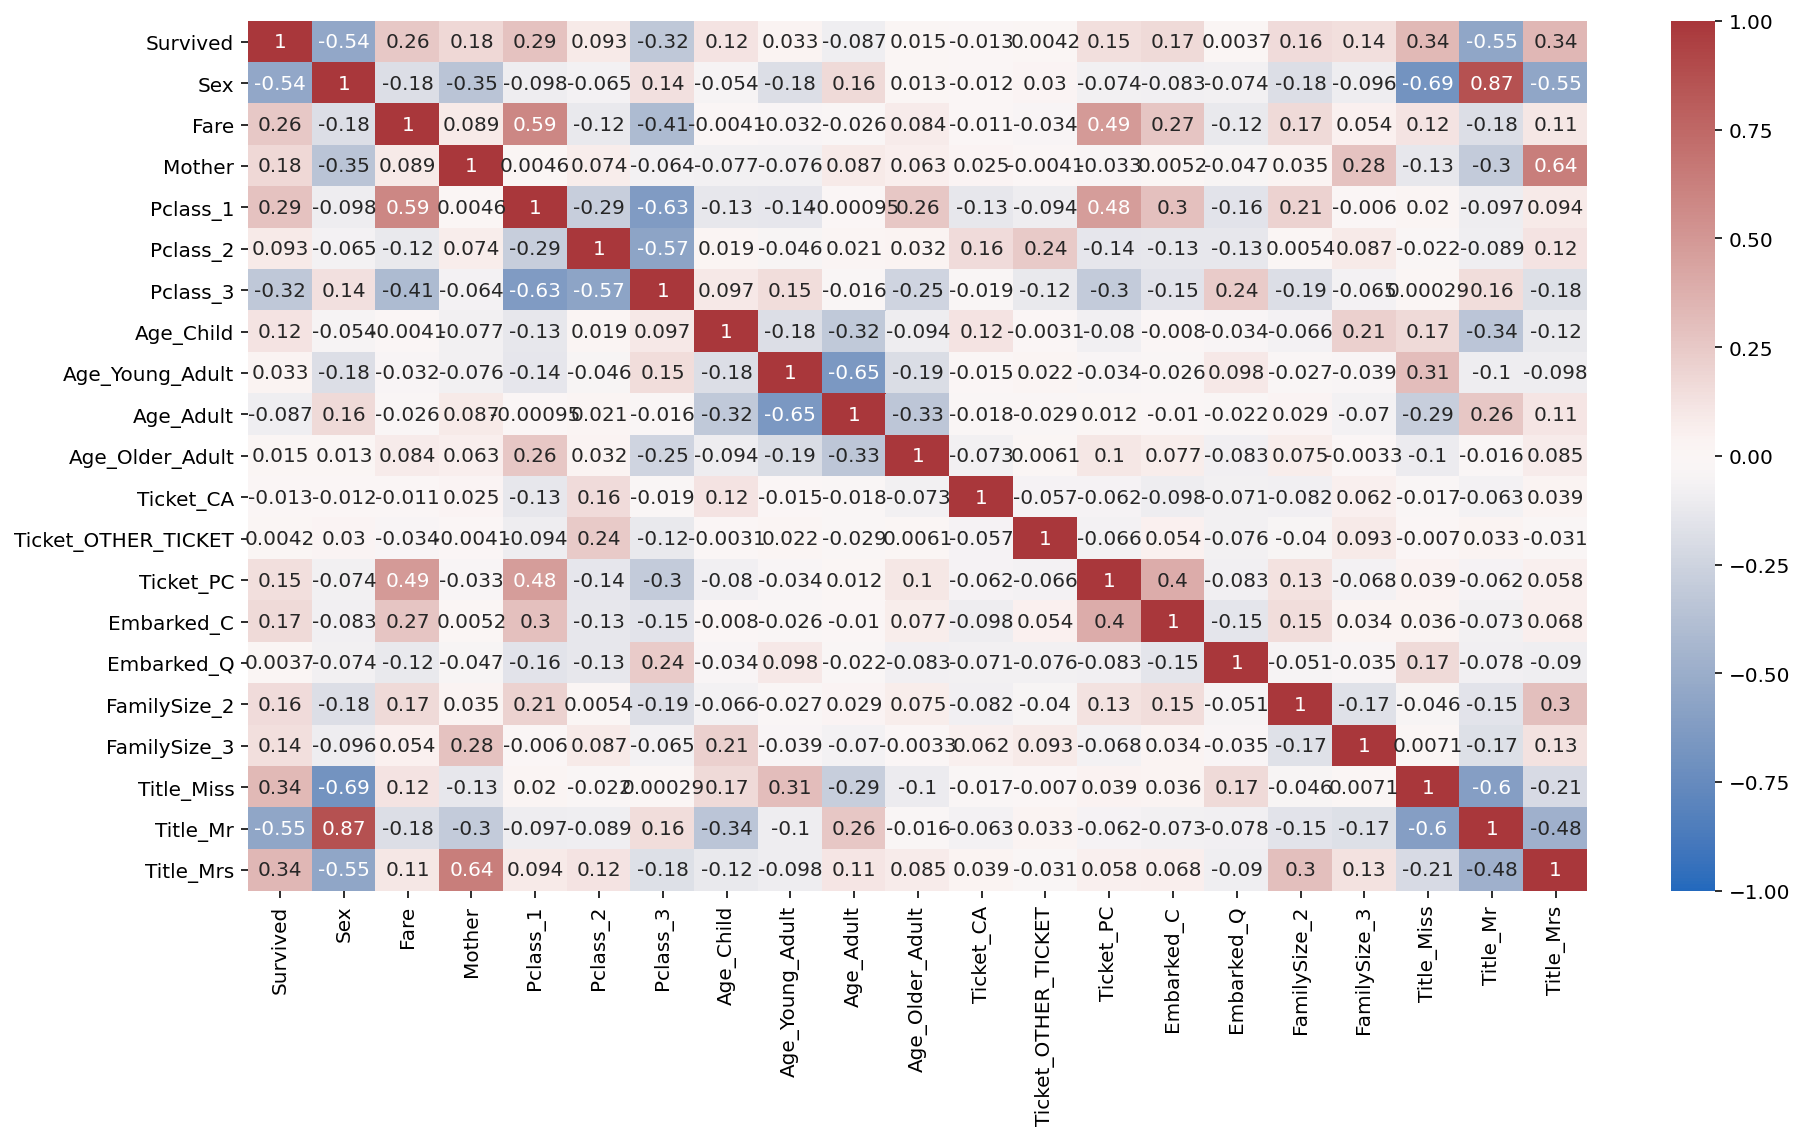

In [1761]:
var = VarianceThreshold(threshold=(.95 * (1 - .95)))
var.fit_transform(df,df.Survived)
df = df[df.columns[var.get_support(indices=True)]]

train_corr = df.loc[traindf.index].corr()
plt.figure(figsize=(15,8))
sns.heatmap(train_corr,center=0,vmin=-1, vmax=1,cmap='vlag', annot=True);

In [1762]:
CORR_THRESHOLD = 0.004
corr_with_target = abs(train_corr['Survived'])
selected_columnes_by_corr = corr_with_target[corr_with_target > CORR_THRESHOLD]
selected_columnes_by_corr

Survived               1.000000
Sex                    0.543351
Fare                   0.257307
Mother                 0.175967
Pclass_1               0.285904
Pclass_2               0.093349
Pclass_3               0.322308
Age_Child              0.117636
Age_Young_Adult        0.032829
Age_Adult              0.086860
Age_Older_Adult        0.015326
Ticket_CA              0.013413
Ticket_OTHER_TICKET    0.004215
Ticket_PC              0.147062
Embarked_C             0.168240
FamilySize_2           0.163157
FamilySize_3           0.143869
Title_Miss             0.335636
Title_Mr               0.549199
Title_Mrs              0.341994
Name: Survived, dtype: float64

In [1763]:
X = df[list(selected_columnes_by_corr.index)].loc[traindf.index].drop(['Survived'],axis=1)
y = df.Survived.loc[traindf.index]

In [1764]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state=42)
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

In [1765]:
# rf_m = RandomForestClassifier(n_estimators=500,random_state=42)
# est = RFECV(estimator=rf_m, step=1, cv=kfold, scoring='f1_weighted')
# est.fit(X_train,y_train);
# print(classification_report(y_test, est.predict(X_test)))

In [1766]:
# print("Optimal number of features : %d" % est.n_features_)
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(est.grid_scores_) + 1), est.grid_scores_)
# plt.show()
# print(X.columns[est.support_])

In [1767]:
# rf_m.fit(X_train,y_train)
# pd.DataFrame(rf_m.feature_importances_, index=X.columns, columns=['feature importance'])\
# .sort_values('feature importance').plot(kind='barh');

In [1768]:
# X = df[X.columns[est.support_]].loc[traindf.index]
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state=42)

# model selection:

In [1769]:
for model in [
    LogisticRegression,
    SVC,
    RandomForestClassifier,
    xgboost.XGBClassifier]:
    cls = model()
    s = cross_val_score(cls, X, y, scoring="roc_auc", cv=kfold)

    print(f"{model.__name__ :22} AUC: {s.mean(): .3f} STD: {s.std(): .2f}")

LogisticRegression     AUC:  0.851 STD:  0.04
SVC                    AUC:  0.846 STD:  0.04
RandomForestClassifier AUC:  0.861 STD:  0.03
XGBClassifier          AUC:  0.871 STD:  0.04


## let's consider RandomForest & XGB models
### 1. RandomForestClassifier

In [1770]:
# parameters = {'n_estimators':range(400,1000,200),
#               'criterion': ['entropy'],
#               'min_samples_split':[8],
#               'min_samples_leaf':[2],
#               'max_depth': [8]}
# rf_clf = GridSearchCV(RandomForestClassifier(max_features='auto', oob_score=True, random_state=42),
#                       parameters, cv=kfold, n_jobs=-1,scoring='f1_weighted')

# rf_clf.fit(X_train, y_train)
# rf_predicted = rf_clf.predict(X_test)

# print('RandomForest:')
# print(classification_report(y_test, rf_predicted))
# print('\n' + str(rf_clf.best_estimator_))

In [1771]:
# pd.DataFrame(rf_clf.best_estimator_.feature_importances_, index=X.columns, columns=['feature importance'])\
# .sort_values('feature importance').plot(kind='barh');

In [1772]:
parameters = {'learning_rate': np.arange(0.001,0.1, 0.005),
              'max_depth': [6],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [1000, 2000, 3000]}
xgb_clf = GridSearchCV(xgboost.XGBClassifier(random_state=42), parameters, n_jobs=-1, 
                       cv=kfold, scoring='f1_weighted', refit=True)

xgb_clf.fit(X_train, y_train)
xgb_predicted = xgb_clf.predict(X_test)

print(classification_report(y_test, xgb_predicted))
print('\n' + str(xgb_clf.best_estimator_))

              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89       105
         1.0       0.83      0.86      0.85        74

    accuracy                           0.87       179
   macro avg       0.87      0.87      0.87       179
weighted avg       0.87      0.87      0.87       179


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.011, max_delta_step=0, max_depth=6,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)


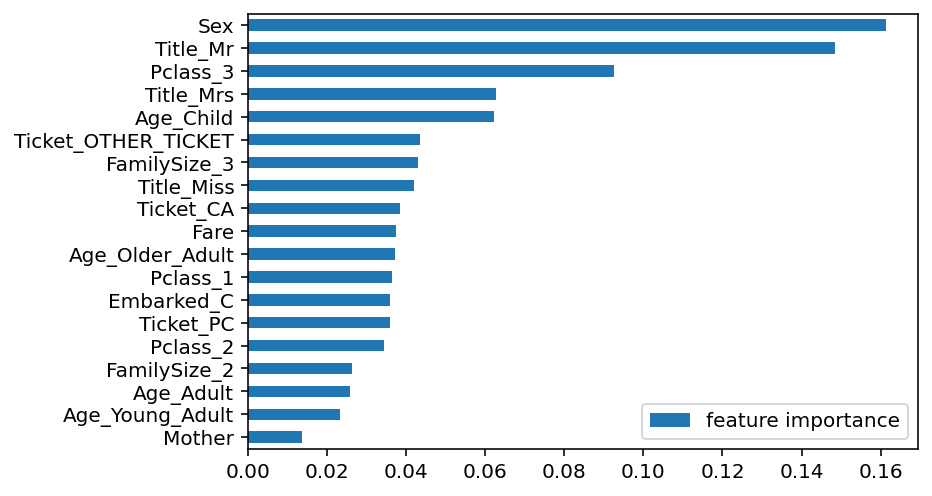

In [1773]:
pd.DataFrame(xgb_clf.best_estimator_.feature_importances_, index=X.columns, columns=['feature importance'])\
.sort_values('feature importance').plot(kind='barh');

In [1774]:
# rf_score = f1_score(y_test, rf_predicted, average='weighted')
# xgb_score = f1_score(y_test, xgb_predicted, average='weighted')
# predictor = xgb_clf.best_estimator_ if xgb_score > rf_score else rf_clf.best_estimator_

In [1775]:
predictdf = df[X.columns].loc[testdf.index]
submission = pd.DataFrame({'PassengerId':predictdf.index,'Survived':xgb_clf.best_estimator_.predict(predictdf)})
submission.Survived = submission.Survived.astype(int)
submission.set_index('PassengerId',inplace=True)
submission.to_csv("titanic_submission_result.csv")